In [8]:
import Pkg; Pkg.add("Agents")
import Pkg; Pkg.add("Random")
import Pkg; Pkg.add("DataFrames")
import Pkg; Pkg.add("CSV")
import Pkg; Pkg.add("DrWatson")
import Pkg; Pkg.add("StatsPlots")
import Pkg; Pkg.add("BenchmarkTools")

  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
Updating `~/.julia/environments/v1.5/Project.toml`
  [9a3f8284] + Random
No Changes to `~/.julia/environments/v1.5/Manifest.toml`
  Resolving package versions...
  Installed DataFrames ─ v0.21.6
Updating `~/.julia/environments/v1.5/Project.toml`
  [a93c6f00] + DataFrames v0.21.6
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [a93c6f00] ↑ DataFrames v0.21.5 ⇒ v0.21.6
  Resolving package versions...
  Installed SentinelArrays ─ v1.2.10
  Installed CSV ──────────── v0.7.7
Updating `~/.julia/environments/v1.5/Project.toml`
  [336ed68f] + CSV v0.7.7
Updating `~/.julia/environments/v1.5/Manifest.toml`
  [336ed68f] + CSV v0.7.7
  [91c51154] + SentinelArrays v1.2.10
  Resolving package versions...
  Installed UnPack ─── v1.0.1
  Installed DrWatson ─ v1.14.7
  Installed FileIO ─── v1.4.0
Updating `~/.julia/environ

<https://github.com/epirecipes/sir-julia/blob/master/script/abm/abm.jl>

┌ Info: Precompiling Agents [46ada45e-f475-11e8-01d0-f70cc89e6671]
└ @ Base loading.jl:1278
┌ Info: Precompiling DrWatson [634d3b9d-ee7a-5ddf-bec9-22491ea816e1]
└ @ Base loading.jl:1278
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1278
┌ Info: Precompiling BenchmarkTools [6e4b80f9-dd63-53aa-95a3-0cdb28fa8baf]
└ @ Base loading.jl:1278


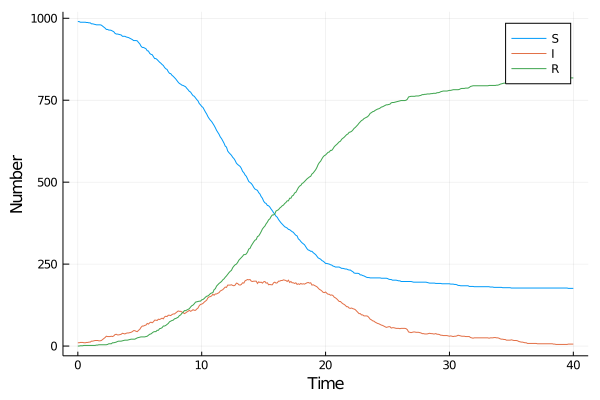

In [9]:
using Agents
using Random
using DataFrames
using Distributions
using DrWatson
using StatsPlots
using BenchmarkTools


function rate_to_proportion(r::Float64,t::Float64)
    1-exp(-r*t)
end;


mutable struct Person <: AbstractAgent
    id::Int64
    status::Symbol
end


function init_model(β::Float64,c::Float64,γ::Float64,N::Int64,I0::Int64)
    properties = @dict(β,c,γ)
    model = ABM(Person; properties=properties)
    for i in 1:N
        if i <= I0
            s = :I
        else
            s = :S
        end
        p = Person(i,s)
        p = add_agent!(p,model)
    end
    return model
end;


function agent_step!(agent, model)
    transmit!(agent, model)
    recover!(agent, model)
end;


function transmit!(agent, model)
    # If I'm not susceptible, I return
    agent.status != :S && return
    ncontacts = rand(Poisson(model.properties[:c]))
    for i in 1:ncontacts
        # Choose random individual
        alter = random_agent(model)
        if alter.status == :I && (rand() ≤ model.properties[:β])
            # An infection occurs
            agent.status = :I
            break
        end
    end
end;


function recover!(agent, model)
    agent.status != :I && return
    if rand() ≤ model.properties[:γ]
            agent.status = :R
    end
end;


susceptible(x) = count(i == :S for i in x)
infected(x) = count(i == :I for i in x)
recovered(x) = count(i == :R for i in x);


δt = 0.1
nsteps = 400
tf = nsteps*δt
t = 0:δt:tf;


β = 0.05
c = 10.0*δt
γ = rate_to_proportion(0.25,δt);


N = 1000
I0 = 10;


Random.seed!(1234);


abm_model = init_model(β,c,γ,N,I0)


to_collect = [(:status, f) for f in (susceptible, infected, recovered)]
abm_data, _ = run!(abm_model, agent_step!, nsteps; adata = to_collect);


abm_data[!,:t] = t;


plot(t,abm_data[:,2],label="S",xlab="Time",ylabel="Number")
plot!(t,abm_data[:,3],label="I")
plot!(t,abm_data[:,4],label="R")